In [1]:
import numpy as np
import glob
from tqdm import tqdm_notebook as tqdm
from hera_cal import io
import matplotlib.pyplot as plt
from hera_cal import flag_utils
from copy import deepcopy
import pickle
%matplotlib notebook

## Find which antennas are in the data

In [2]:
day_folders = sorted(glob.glob('/lustre/aoc/projects/hera/H1C_IDR3/IDR3_1/245*'))

In [3]:
jds = []
jd_ants = {}
for folder in tqdm(day_folders):
    jds.append(folder.split('/')[-1])
    calfits = sorted(glob.glob(folder + '/*omni.calfits'))
    hc = io.HERACal(calfits[0])
    hc.read()
    jd_ants[jds[-1]] = hc.antenna_numbers
jd_ints = np.array([int(jd) for jd in jds])

In [4]:
all_ants = set([ant for ants in jd_ants.values() for ant in ants])

## Abscal Flags

In [5]:
pickle_file = 'abscal_ex_ants.p'
try:
    pickled = pickle.load(open(pickle_file, 'rb'))
    abscal_ex_ants = pickled['abscal_ex_ants']
    abscal_all_ants = pickled['abscal_all_ants']
    abscal_lsts = pickled['abscal_lsts']
except:
    abscal_files = sorted(glob.glob('/lustre/aoc/projects/hera/nkern/idr3_abscal_models/full_model/zen.245804*.*.HH.uvRXLS.uvh5'))
    abscal_ex_ants = {}
    abscal_all_ants = {}
    abscal_lsts = {}
    for af in tqdm(abscal_files):
        hd = io.HERAData(af)
        _, flags, _ = hd.read()
        ant_flags = flag_utils.synthesize_ant_flags(flags)
        abscal_all_ants[af] = list(ant_flags.keys())
        abscal_ex_ants[af] = [ant for ant in ant_flags if np.all(ant_flags[ant])]
        abscal_lsts[af] = hd.lsts
    with open(pickle_file, 'wb') as p:
        pickle.dump({'abscal_ex_ants': abscal_ex_ants, 'abscal_all_ants': abscal_all_ants, 'abscal_lsts': abscal_lsts}, p)
    
abscal_all_ants_set = set([ant for ants in abscal_all_ants.values() for ant in ants])

In [6]:
for af in abscal_ex_ants:
    for ant in abscal_ex_ants[af]:
        assert (ant[0], 'Jnn') in abscal_ex_ants[af]
        assert (ant[0], 'Jee') in abscal_ex_ants[af]

In [7]:
for ant in abscal_all_ants_set:
    for af in abscal_all_ants:
        assert (ant[0], 'Jnn') in abscal_all_ants[af]
        assert (ant[0], 'Jee') in abscal_all_ants[af]        

In [8]:
abscal_flag_frac = {ant[0]: len([af for af in abscal_ex_ants if ant in abscal_ex_ants[af]]) / len(abscal_ex_ants) for ant in abscal_all_ants_set}

counts = []
for ant in abscal_all_ants_set:
    if len([af for af in abscal_ex_ants if ant in abscal_ex_ants[af]]) > 0:
        counts.append([len([af for af in abscal_ex_ants if ant in abscal_ex_ants[af]]) / len(abscal_ex_ants), ant])
print('Abscal Flag Fraction / Antenna')
sorted(counts)[::-1]

Abscal Flag Fraction / Antenna


[[1.0, (338, 'Jnn')],
 [1.0, (338, 'Jee')],
 [1.0, (334, 'Jnn')],
 [1.0, (334, 'Jee')],
 [1.0, (183, 'Jnn')],
 [1.0, (183, 'Jee')],
 [1.0, (182, 'Jnn')],
 [1.0, (182, 'Jee')],
 [1.0, (181, 'Jnn')],
 [1.0, (181, 'Jee')],
 [1.0, (180, 'Jnn')],
 [1.0, (180, 'Jee')],
 [1.0, (156, 'Jnn')],
 [1.0, (156, 'Jee')],
 [1.0, (155, 'Jnn')],
 [1.0, (155, 'Jee')],
 [1.0, (116, 'Jnn')],
 [1.0, (116, 'Jee')],
 [1.0, (104, 'Jnn')],
 [1.0, (104, 'Jee')],
 [1.0, (99, 'Jnn')],
 [1.0, (99, 'Jee')],
 [1.0, (98, 'Jnn')],
 [1.0, (98, 'Jee')],
 [1.0, (50, 'Jnn')],
 [1.0, (50, 'Jee')],
 [1.0, (14, 'Jnn')],
 [1.0, (14, 'Jee')],
 [0.7830188679245284, (119, 'Jnn')],
 [0.7830188679245284, (119, 'Jee')],
 [0.7830188679245284, (118, 'Jnn')],
 [0.7830188679245284, (118, 'Jee')],
 [0.7830188679245284, (117, 'Jnn')],
 [0.7830188679245284, (117, 'Jee')],
 [0.7830188679245284, (103, 'Jnn')],
 [0.7830188679245284, (103, 'Jee')],
 [0.7830188679245284, (102, 'Jnn')],
 [0.7830188679245284, (102, 'Jee')],
 [0.7830188679245284, 

## Analyze Logs

In [9]:
logs = sorted(glob.glob('/users/jsdillon/lustre/H1C_IDR3_redcal/late-2019-run-logs/*.log'))
print(len(logs))
ex_ants = {jd: {} for jd in jds}
ex_ants_apriori = {jd: {} for jd in jds}
for log in tqdm(logs):
    with open(log,'r') as file:
        jd = log.split('/zen.')[-1].split('.')[0]
        time = log.split('/zen.')[-1].split('.xx')[0]
        txt = file.read().replace('\n', '').split('without antennas ')
        try:
            ex_ants[jd][time] = np.array(eval(txt[-1].split(' ...')[0]))
            ex_ants_apriori[jd][time] = np.array(eval(txt[1].split(' ...')[0]))
        except:
            print('Failed on', time)
#             print(txt)

7767


In [21]:
# logs = sorted(glob.glob('/lustre/aoc/projects/hera/H1C_IDR3/IDR3_1/makeflow/245*/*REDCAL*.log'))
# print(len(logs))
# ex_ants = {jd: {} for jd in jds}
# ex_ants_apriori = {jd: {} for jd in jds}
# for log in tqdm(logs):
#     with open(log,'r') as file:
#         jd = log.split('/')[-2]
#         time = log.split('/zen.')[-1].split('.xx')[0]
#         txt = file.read().replace('\n', '').split('without antennas ')
#         try:
#             ex_ants[jd][time] = np.array(eval(txt[-1].split(' ...')[0]))
#             ex_ants_apriori[jd][time] = np.array(eval(txt[1].split(' ...')[0]))
#         except:
#             print('Failed on', time)
# #             print(txt)

In [10]:
ever_flagged = set([ant for jd in ex_ants for time in ex_ants[jd] for ant in ex_ants[jd][time]])

In [11]:
ant_flag_fraction = {ant: np.array([np.sum([ant in ex_ants[jd][time] for time in ex_ants[jd]]) / 
                           len(ex_ants[jd]) if ant in jd_ants[jd] else np.nan for jd in ex_ants]) for ant in ever_flagged.union(all_ants)}
ant_flag_apriori_fraction = {ant: np.array([np.sum([ant in ex_ants_apriori[jd][time] for time in ex_ants_apriori[jd]]) / 
                                   len(ex_ants_apriori[jd]) if ant in jd_ants[jd] else np.nan for jd in ex_ants_apriori]) for ant in ever_flagged.union(all_ants)}

In [12]:
new_flag_levels = sorted([(np.nanmean(np.array(ant_flag_fraction[ant]) - np.array(ant_flag_apriori_fraction[ant])), ant) for ant in ever_flagged.union(all_ants)])[::-1]

In [13]:
# TODO: figure out why this doesn't quite match the flagging in IDR 2.2

In [14]:
IDR22_excluded = [155, 156, 180, 181, 182, 183, 334, 338, 0, 11, 24, 50, 53, 54, 67, 69, 98, 122, 136]

In [22]:
verdicts = {54: 'Completely Flagged',
            136: 'Completely Flagged',
            69: 'Completely Flagged',
            53: 'Completely Flagged',
            117: 'Completely Flagged',
            24: 'Completely Flagged',
            67: 'Flagged Epoch 1, 2, 3',
            122: 'No New Flags',
            52: 'No New Flags',
            118: 'Flagged Epoch 3',
            137: 'No New Flags',
            12: 'No New Flags',
            84: 'No New Flags',
            41: 'Flagged on 2458141',
            100: 'No New Flags',
            87: 'No New Flags',
            1: 'No New Flags',
            102: 'No New Flags',
            23: 'No New Flags',
            11: 'Flagged on 2458190',
            68: 'No New Flags',
            141: 'No New Flags',
            86: 'No New Flags',
            13: 'No New Flags',
            143: 'No New Flags',
            85: 'No New Flags',
            138: 'No New Flags',
            142: 'No New Flags',
            82: 'No New Flags',
            123: 'No New Flags',
            38: 'No New Flags',
            25: 'No New Flags',
            120: 'No New Flags',
            51: 'No New Flags',
            71: 'No New Flags',
            55: 'No New Flags',
            139: 'No New Flags',
            88: 'No New Flags',
            124: 'No New Flags',
            121: 'No New Flags',
            37: 'No New Flags',
            14: 'No New Flags'}

In [23]:
group1 = [2458041, 2458042, 2458043, 2458044, 2458045, 2458046, 2458047, 2458048, 2458049, 2458050, 2458051, 2458052, 2458054, 2458055, 2458056, 2458058, 2458059, 2458061, 2458062, 2458063, 2458064, 2458065, 2458066, 2458067, 2458068, 2458069, 2458070, 2458071, 2458072]
group2 = [2458081, 2458083, 2458084, 2458085, 2458086, 2458087, 2458088, 2458089, 2458090, 2458091, 2458092, 2458094, 2458095, 2458096, 2458097, 2458098, 2458099, 2458101, 2458102, 2458103, 2458104, 2458105, 2458106, 2458107, 2458108, 2458109, 2458110, 2458111, 2458112, 2458113, 2458114, 2458115, 2458116]
group3 = [2458134, 2458135, 2458136, 2458139, 2458140, 2458141, 2458142, 2458143, 2458144, 2458145, 2458146, 2458147, 2458148, 2458149, 2458150, 2458151, 2458153, 2458154, 2458155, 2458157, 2458158, 2458159, 2458161, 2458172, 2458173]
group4 = [2458172, 2458173, 2458185, 2458187, 2458188, 2458189, 2458190, 2458192, 2458195, 2458196, 2458197, 2458198, 2458199, 2458200, 2458201, 2458202, 2458203, 2458204, 2458205, 2458206, 2458207, 2458208]

ant_flag_fraction_final = deepcopy(ant_flag_fraction)

for ant in verdicts:
    if 'Completely' in verdicts[ant]:
        ant_flag_fraction_final[ant][np.isfinite(ant_flag_fraction_final[ant])] = 1.0
    if 'Epoch' in verdicts[ant]:
        for n, group in zip(['1', '2', '3', '4'], [group1, group2, group3, group4] ):
            if n in verdicts[ant]:
                indices = np.array([jd in group for jd in jd_ints])
                ant_flag_fraction_final[ant][indices] = 1.0
    if '245' in verdicts[ant]:
        for ss in verdicts[ant].split(' '):
            try:
                indices = np.array([jd == int(ss) for jd in jd_ints])
                ant_flag_fraction_final[ant][indices] = 1.0
            except:
                pass
        
                                   

            

## Visualization

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


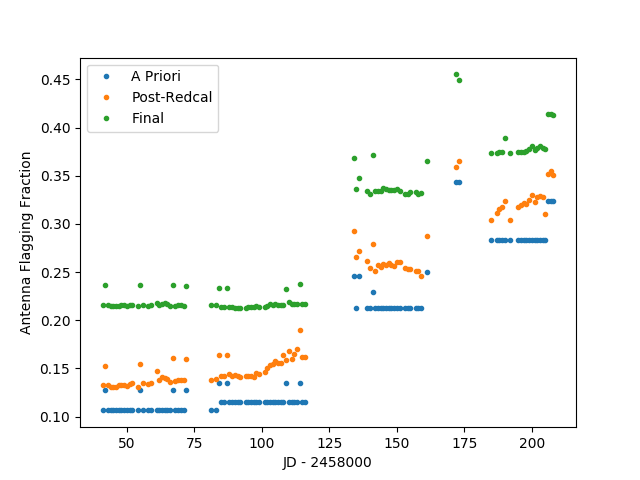

In [24]:
plt.figure()

day_flag_fraction_apriori = [np.nansum([ant_flag_apriori_fraction[ant][jd_ind] for ant in ant_flag_apriori_fraction]) / 
                      np.sum([np.isfinite(ant_flag_apriori_fraction[ant])[jd_ind] for ant in ant_flag_apriori_fraction]) 
                      for jd_ind, jd in enumerate(jds)]

day_flag_fraction = [np.nansum([ant_flag_fraction[ant][jd_ind] for ant in ant_flag_fraction]) / 
                     np.sum([np.isfinite(ant_flag_fraction[ant])[jd_ind] for ant in ant_flag_fraction]) 
                     for jd_ind, jd in enumerate(jds)]

day_flag_fraction_final = [np.nansum([ant_flag_fraction_final[ant][jd_ind] for ant in ant_flag_fraction_final]) / 
                     np.sum([np.isfinite(ant_flag_fraction_final[ant])[jd_ind] for ant in ant_flag_fraction_final]) 
                     for jd_ind, jd in enumerate(jds)]

plt.plot(jd_ints - 2458000, day_flag_fraction_apriori, '.', label='A Priori')
plt.plot(jd_ints - 2458000, day_flag_fraction, '.', label='Post-Redcal')
plt.plot(jd_ints - 2458000, day_flag_fraction_final, '.', label='Final')
plt.xlabel('JD - 2458000')
plt.ylabel('Antenna Flagging Fraction')
plt.legend()

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


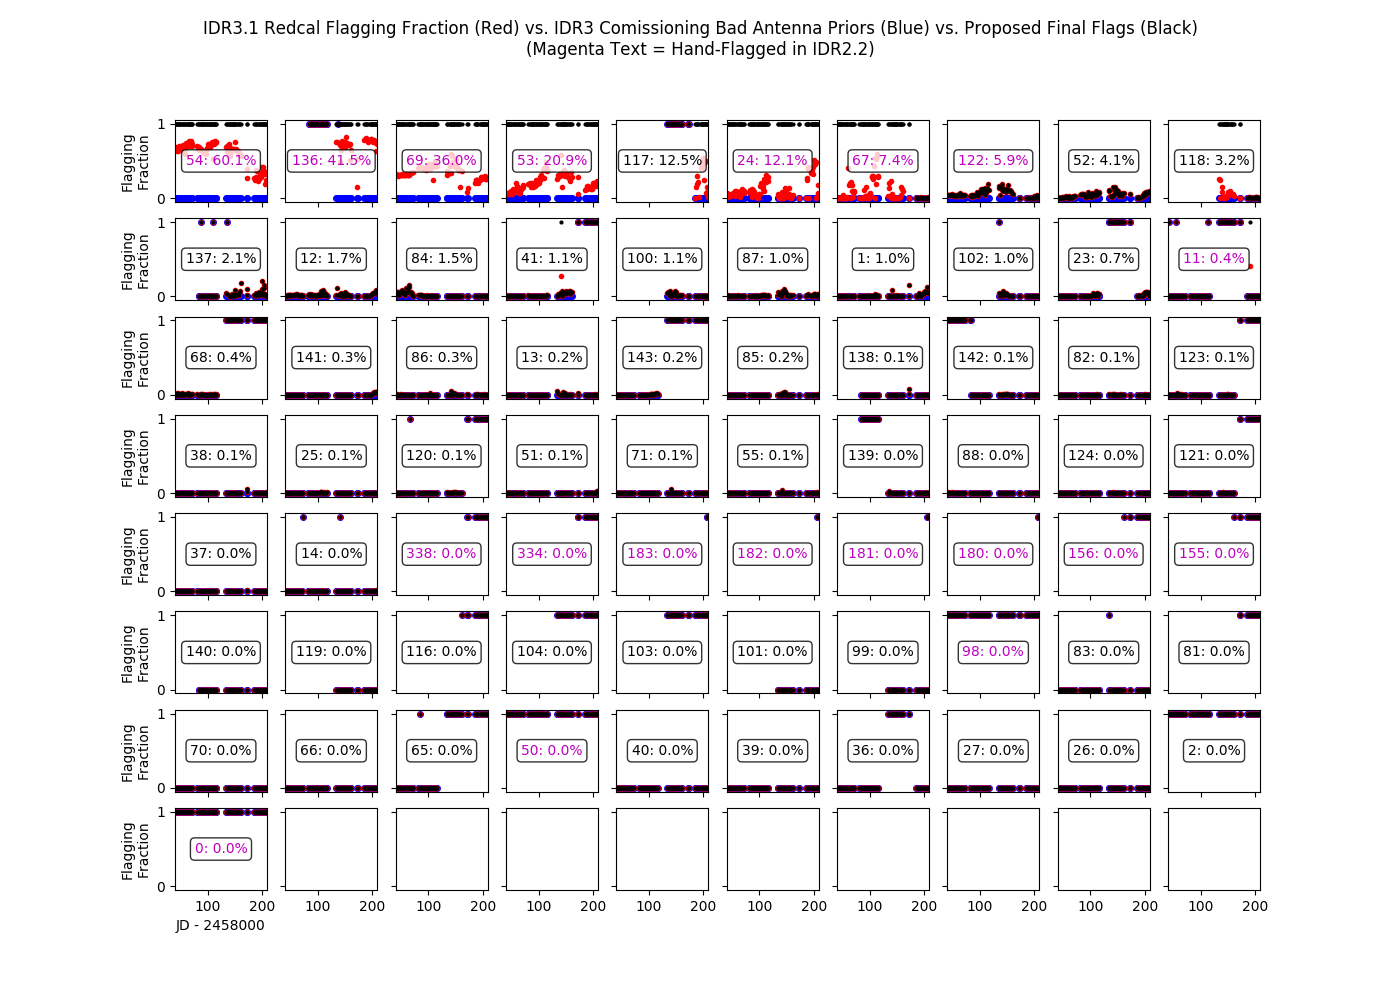

Text(0.5, 0.98, 'IDR3.1 Redcal Flagging Fraction (Red) vs. IDR3 Comissioning Bad Antenna Priors (Blue) vs. Proposed Final Flags (Black)\n(Magenta Text = Hand-Flagged in IDR2.2)')

In [25]:
fig, axes = plt.subplots(8,10, figsize=(14,10), sharex=True, sharey=True)

for n, ax in enumerate(axes.flatten()):
#     plt.title(ant)
    ax.set_ylim([-.05, 1.05])
    ax.set_xlim([np.min(jd_ints)-1-2458000, np.max(jd_ints)+1-2458000])    
    try:
        ant = new_flag_levels[n][1]
    #         ant = sorted(list(ever_flagged.union(all_ants)))[n]
        ax.plot(jd_ints-2458000, ant_flag_apriori_fraction[ant],'bo', ms=4)
        ax.plot(jd_ints-2458000, ant_flag_fraction[ant],'ro', ms=3)
        ax.plot(jd_ints-2458000, ant_flag_fraction_final[ant],'ko', ms=2)
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
#         ax.annotate('{}: {}%\nAC: {}%'.format(ant, round(100*new_flag_levels[n][0],1), round(100*abscal_flag_frac[ant],1)), 
        ax.annotate('{}: {}%'.format(ant, round(100*new_flag_levels[n][0],1)),
                    ((np.max(jd_ints)+np.min(jd_ints))/2 - 2458000, .5), fontsize=10,
                     va='center', ha='center',  bbox=props, color=['k','m'][ant in IDR22_excluded])
        if n >= 70:
            ax.set_xlabel('JD - 2458000')
        if n % 10 == 0:
            ax.set_ylabel('Flagging\nFraction')
    except:
        pass

    
plt.suptitle('IDR3.1 Redcal Flagging Fraction (Red) vs. IDR3 Comissioning Bad Antenna Priors (Blue) vs. Proposed Final Flags (Black)\n(Magenta Text = Hand-Flagged in IDR2.2)')
# plt.tight_layout()

<IPython.core.display.Javascript object>


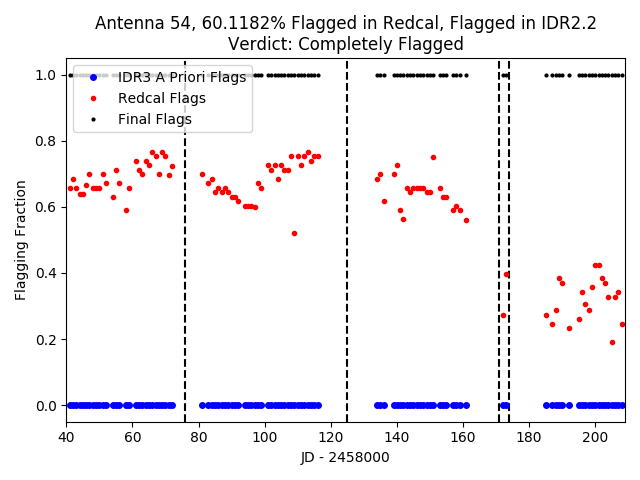

<IPython.core.display.Javascript object>


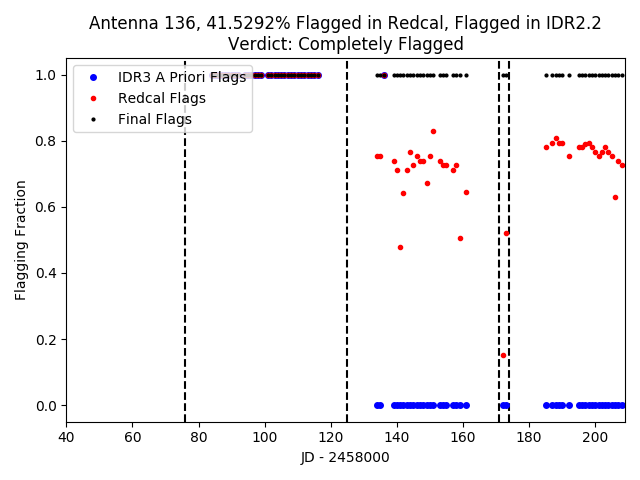

<IPython.core.display.Javascript object>


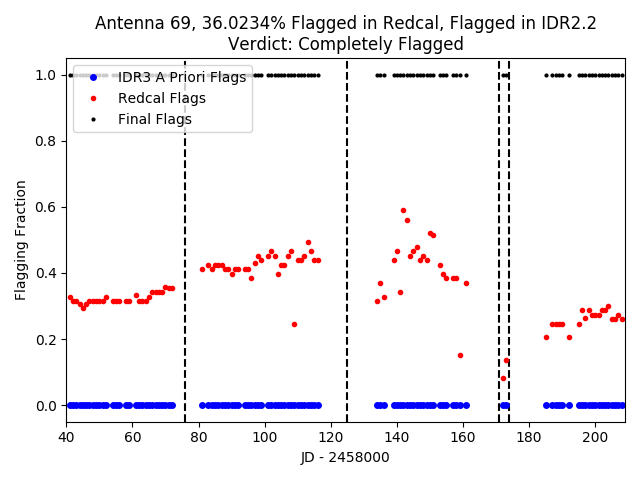

<IPython.core.display.Javascript object>


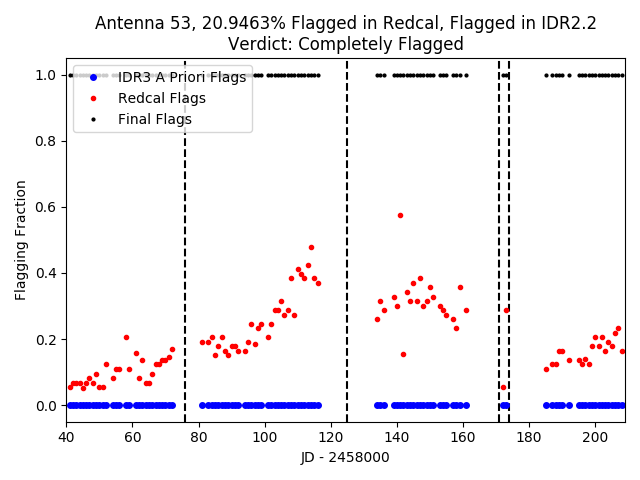

<IPython.core.display.Javascript object>


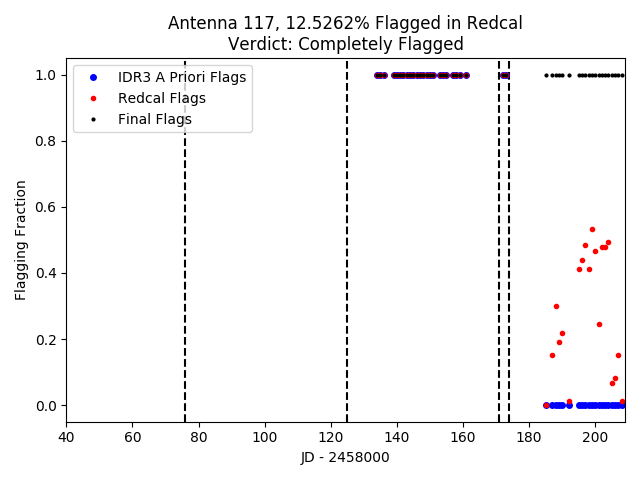

<IPython.core.display.Javascript object>


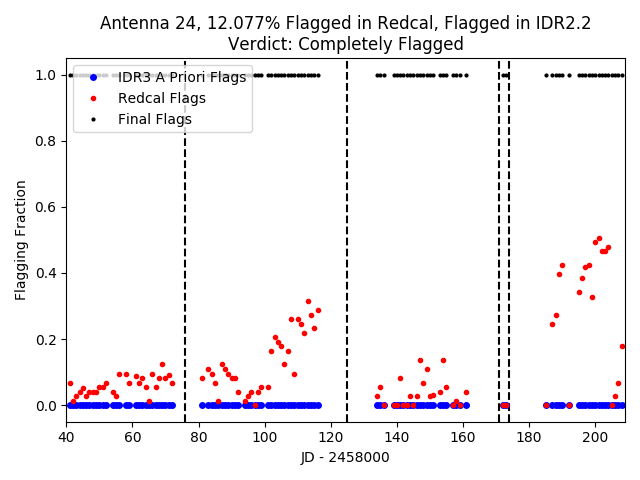

<IPython.core.display.Javascript object>


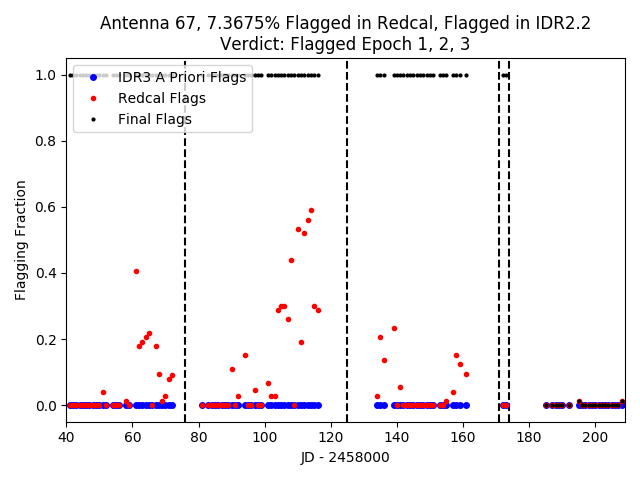

<IPython.core.display.Javascript object>


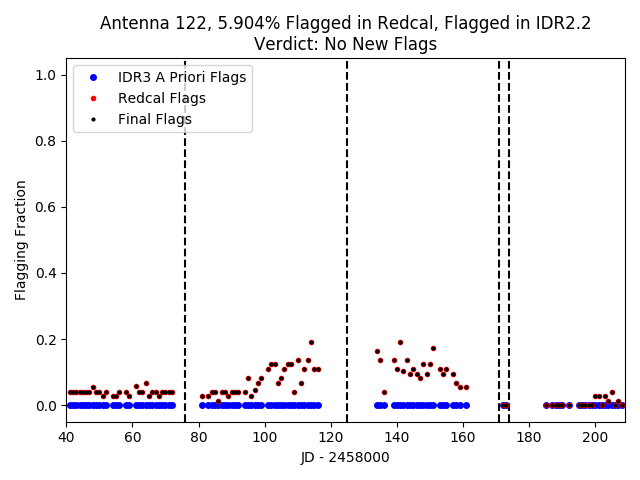

<IPython.core.display.Javascript object>


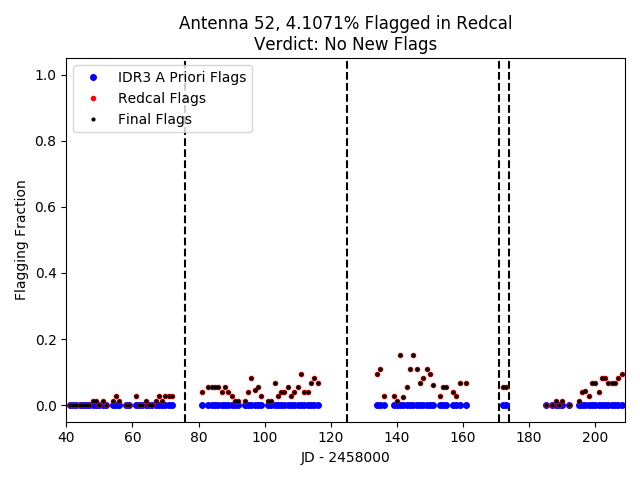

<IPython.core.display.Javascript object>


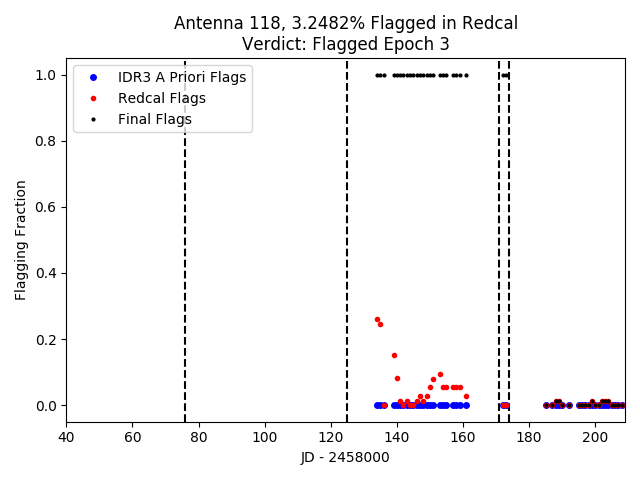

<IPython.core.display.Javascript object>


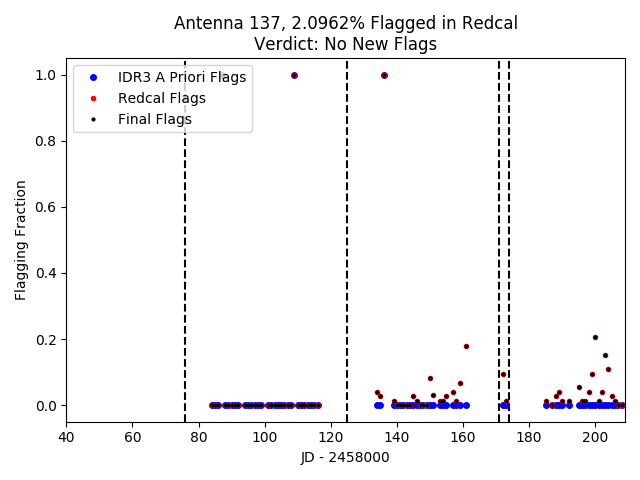

<IPython.core.display.Javascript object>


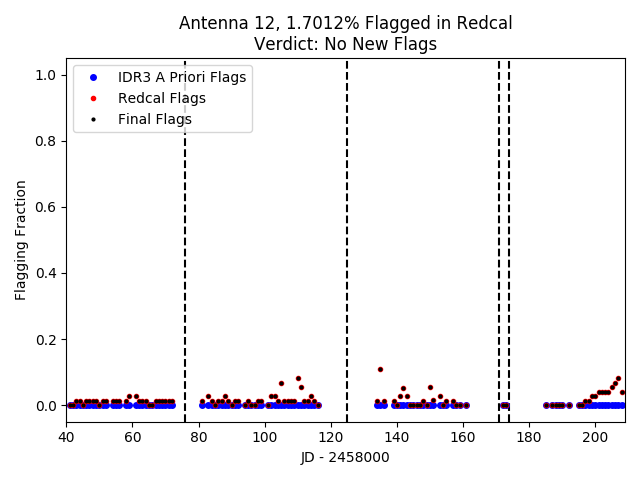

<IPython.core.display.Javascript object>


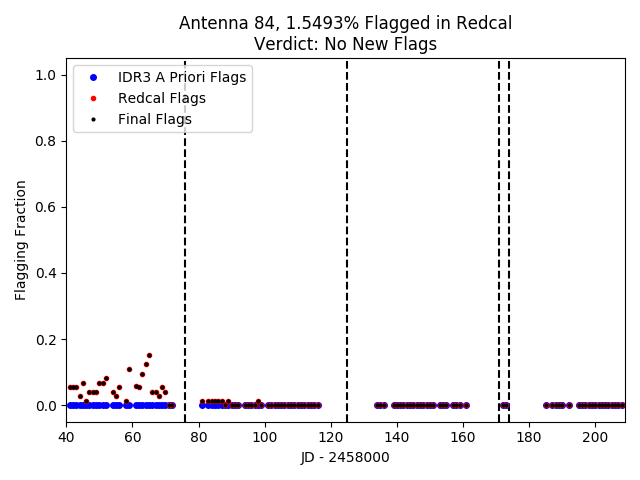

<IPython.core.display.Javascript object>


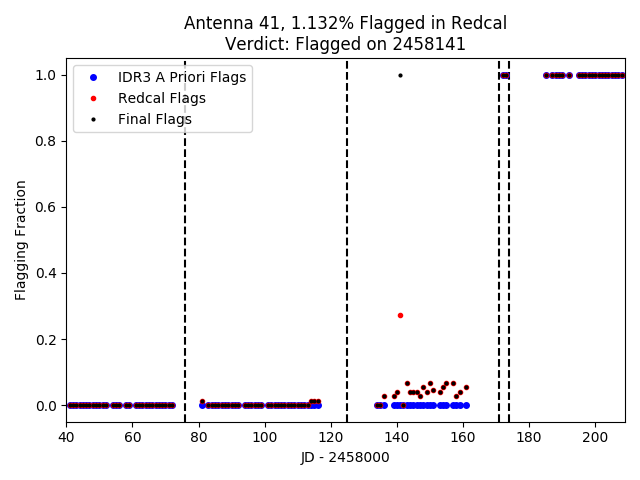

<IPython.core.display.Javascript object>


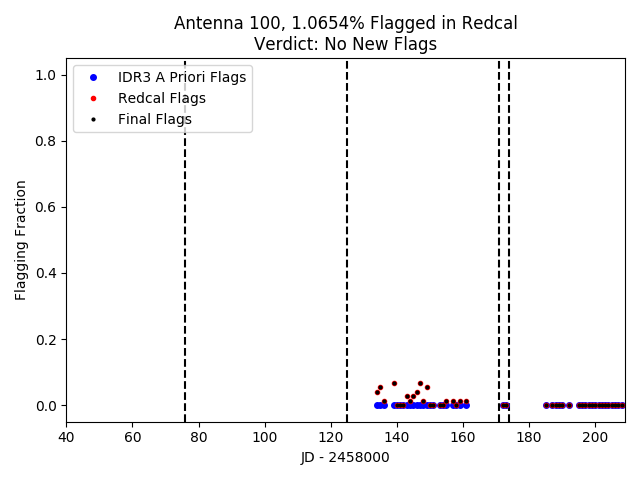

<IPython.core.display.Javascript object>


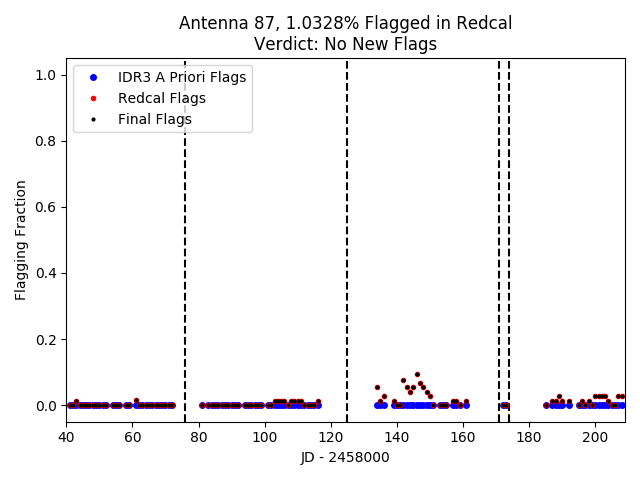

<IPython.core.display.Javascript object>


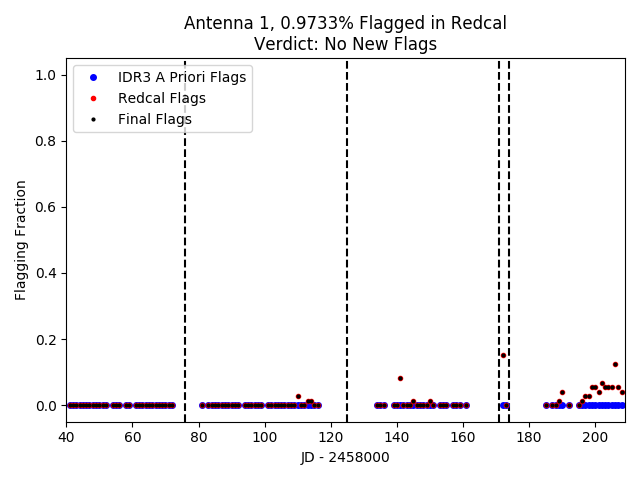

<IPython.core.display.Javascript object>


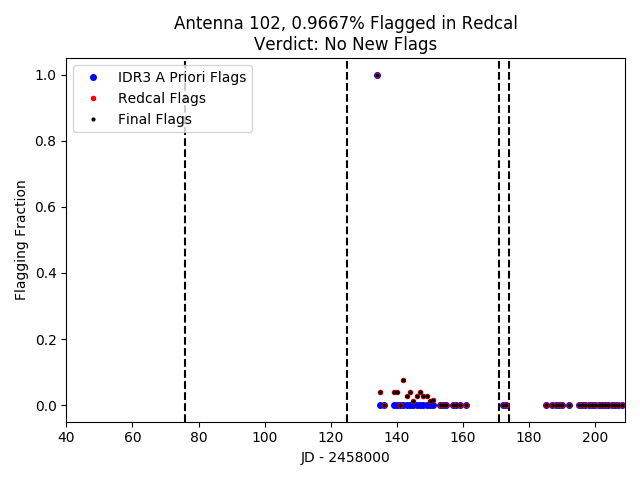

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


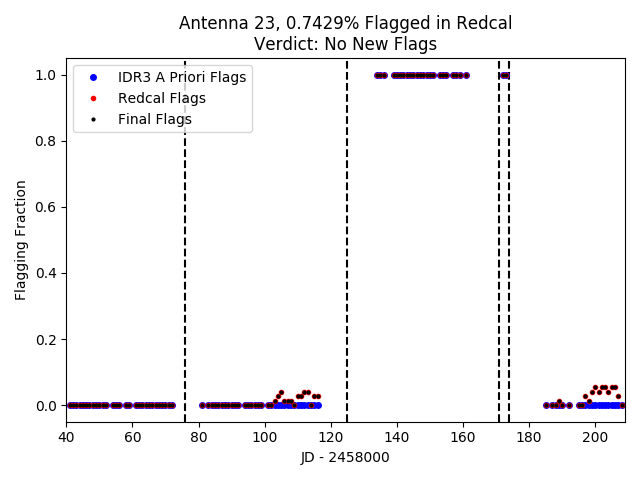

<IPython.core.display.Javascript object>


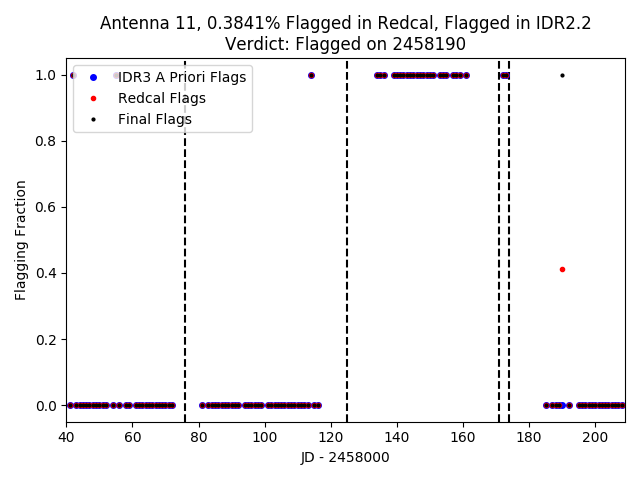

<IPython.core.display.Javascript object>


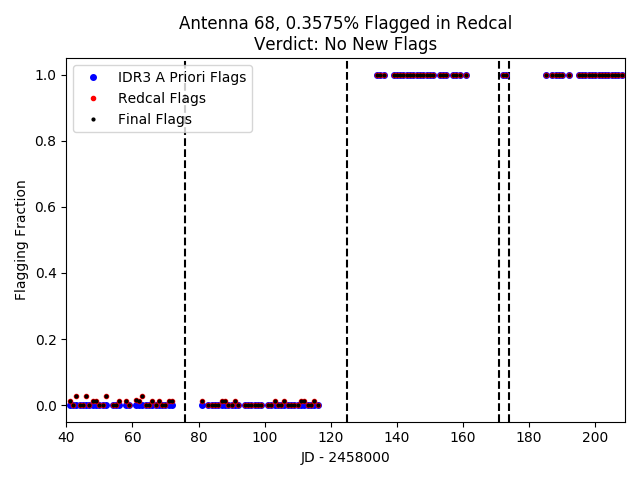

<IPython.core.display.Javascript object>


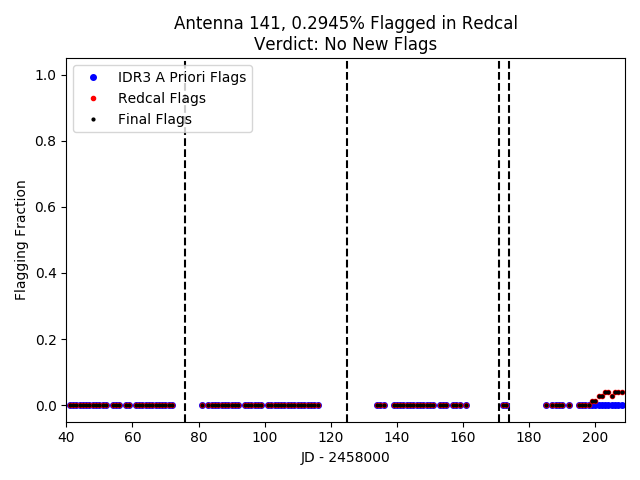

<IPython.core.display.Javascript object>


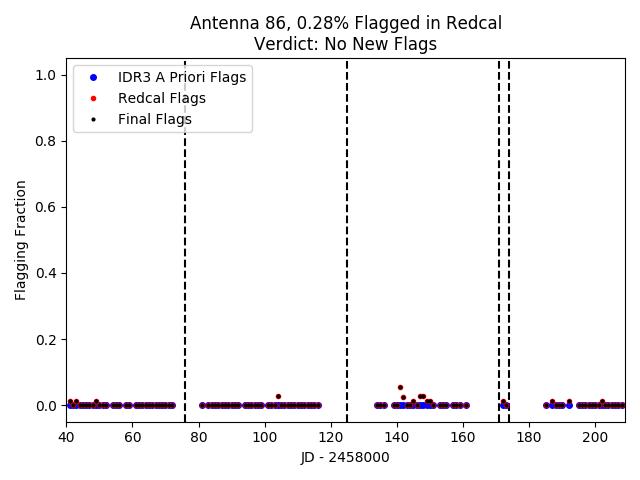

<IPython.core.display.Javascript object>


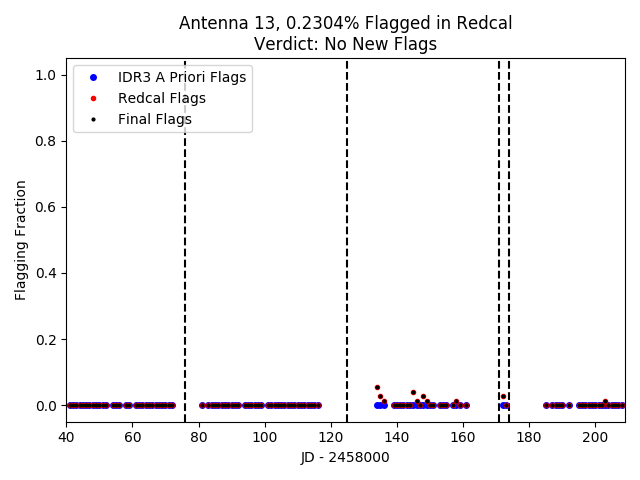

<IPython.core.display.Javascript object>


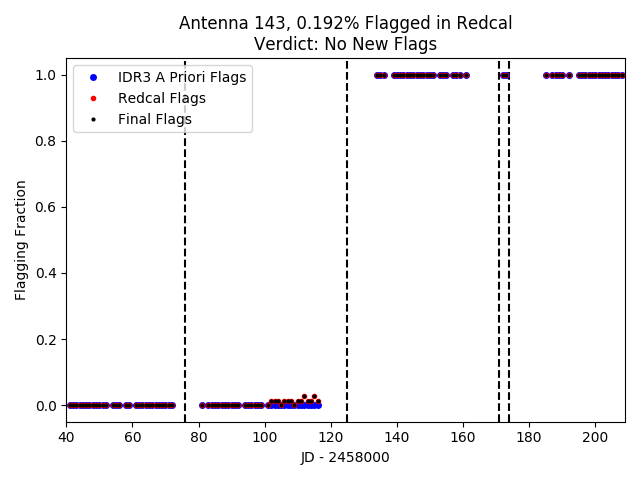

<IPython.core.display.Javascript object>


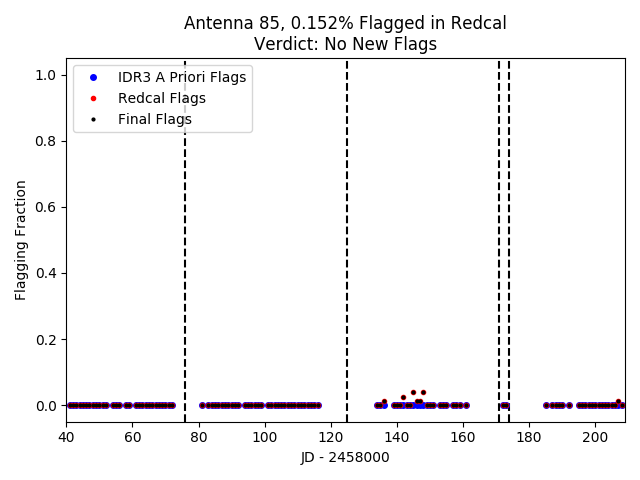

<IPython.core.display.Javascript object>


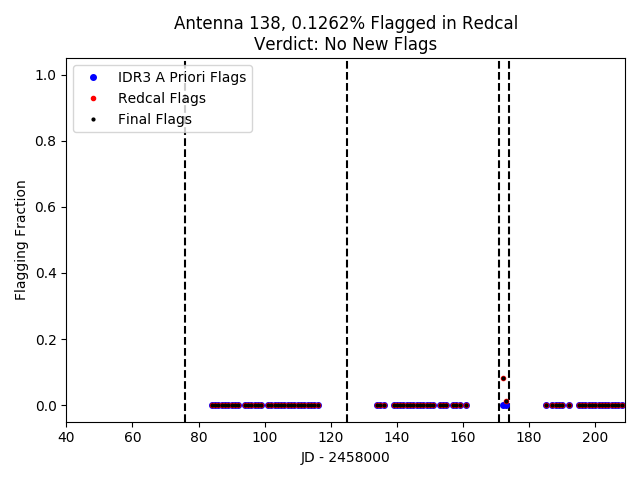

<IPython.core.display.Javascript object>


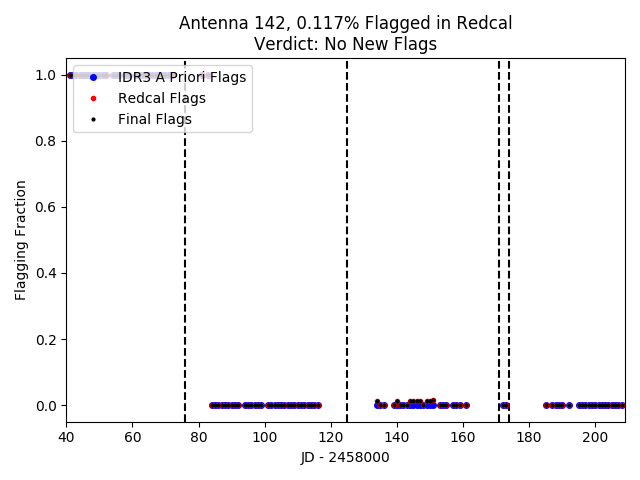

<IPython.core.display.Javascript object>


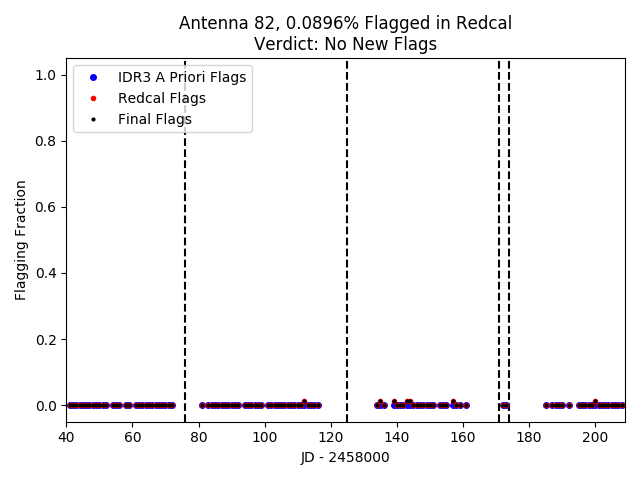

<IPython.core.display.Javascript object>


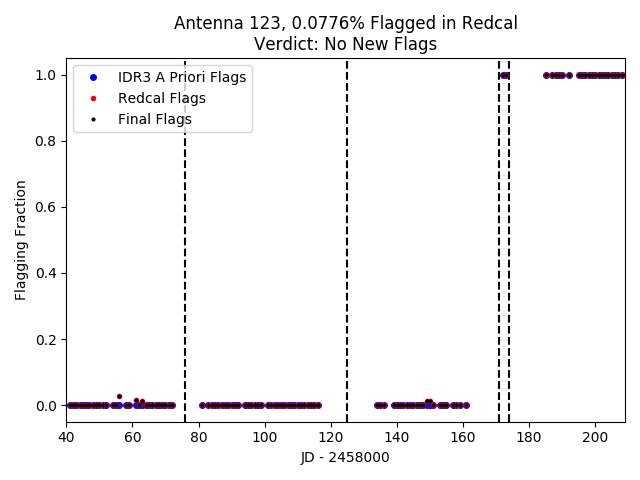

<IPython.core.display.Javascript object>


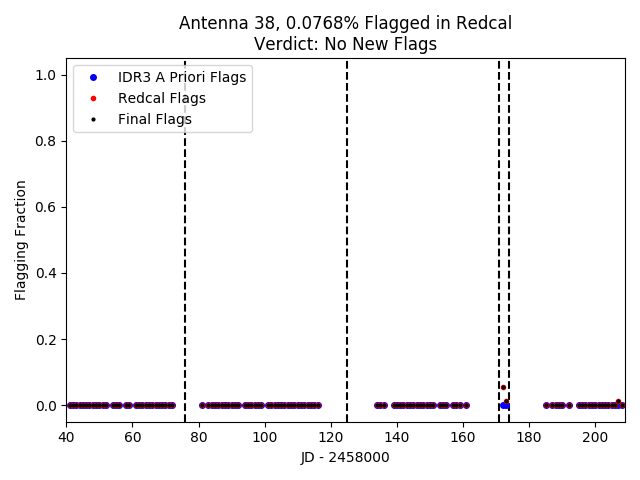

<IPython.core.display.Javascript object>


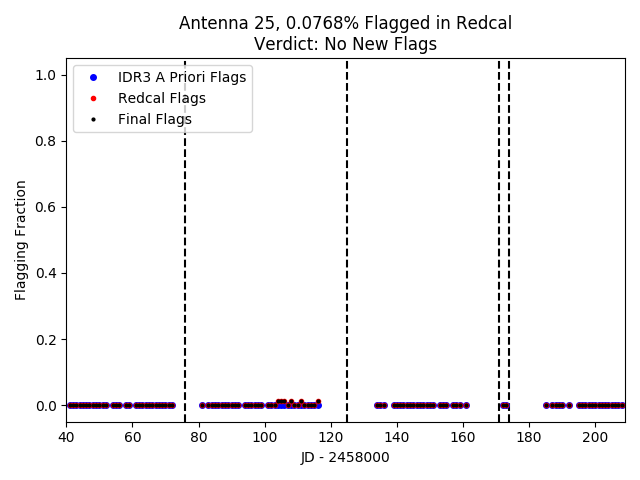

<IPython.core.display.Javascript object>


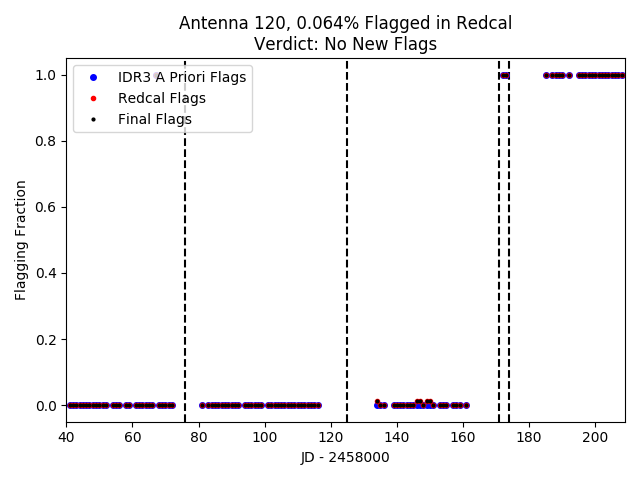

<IPython.core.display.Javascript object>


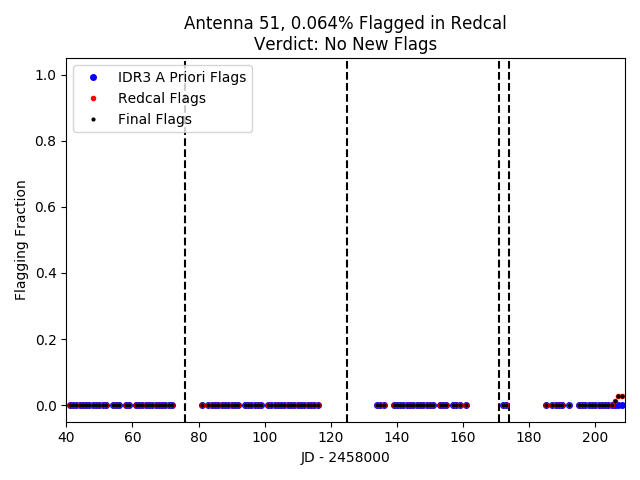

<IPython.core.display.Javascript object>


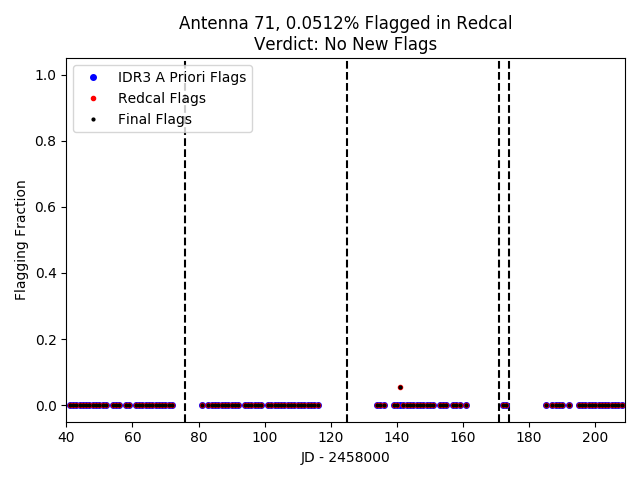

<IPython.core.display.Javascript object>


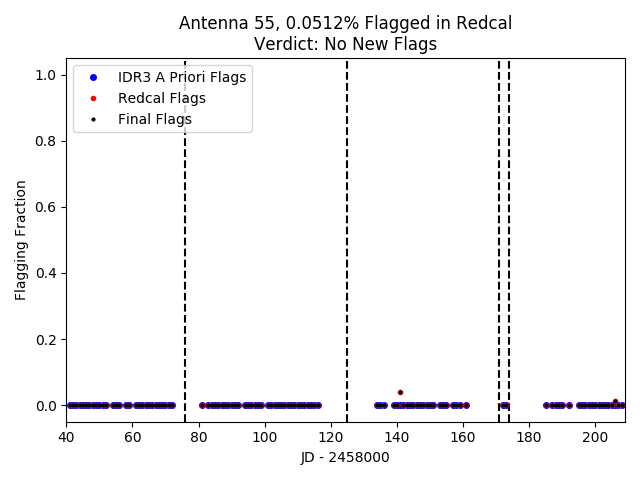

<IPython.core.display.Javascript object>


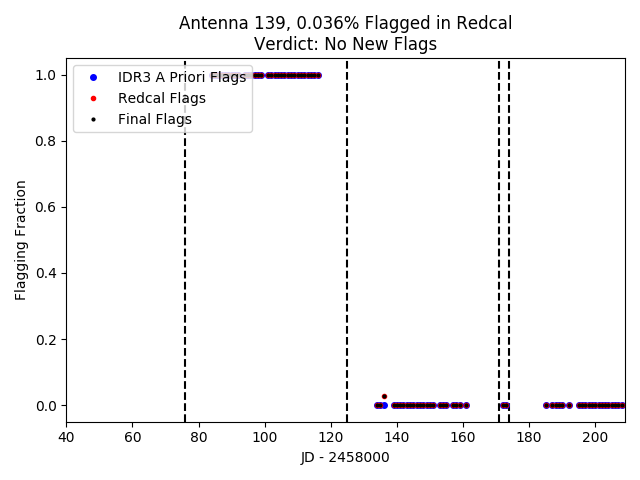

<IPython.core.display.Javascript object>


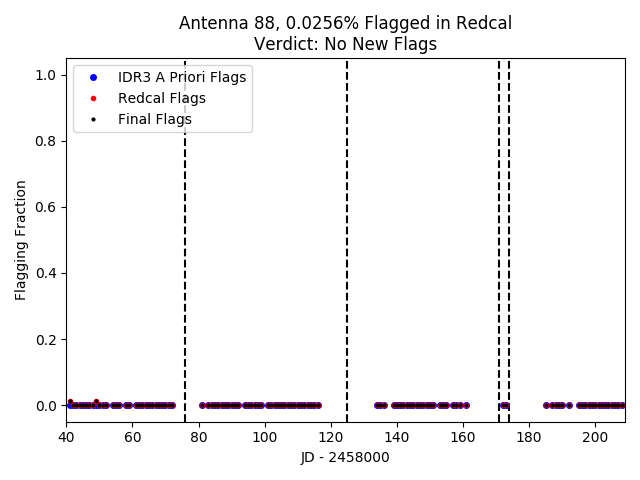

<IPython.core.display.Javascript object>


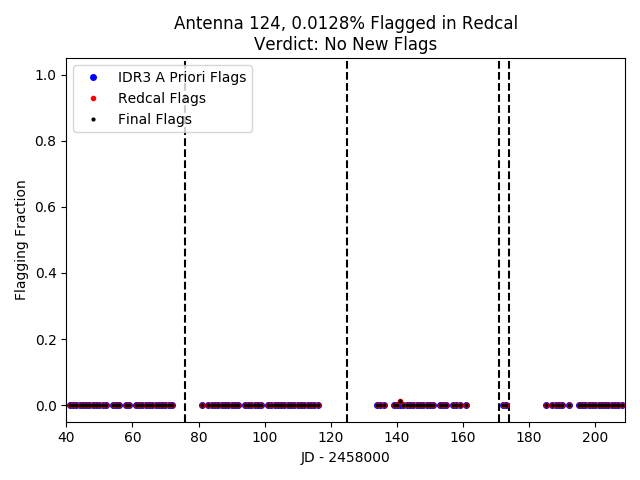

<IPython.core.display.Javascript object>


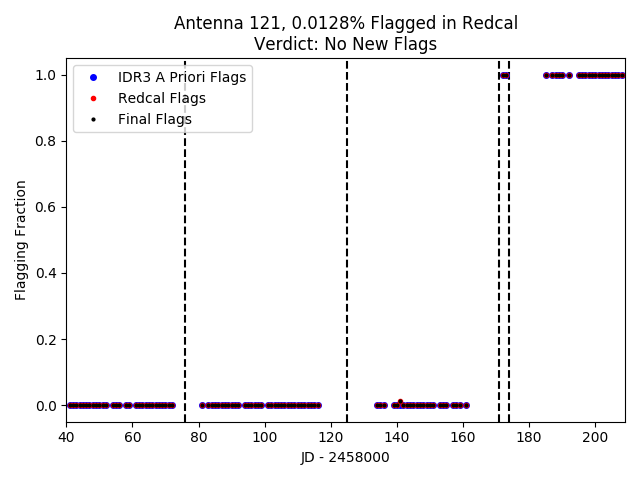

<IPython.core.display.Javascript object>


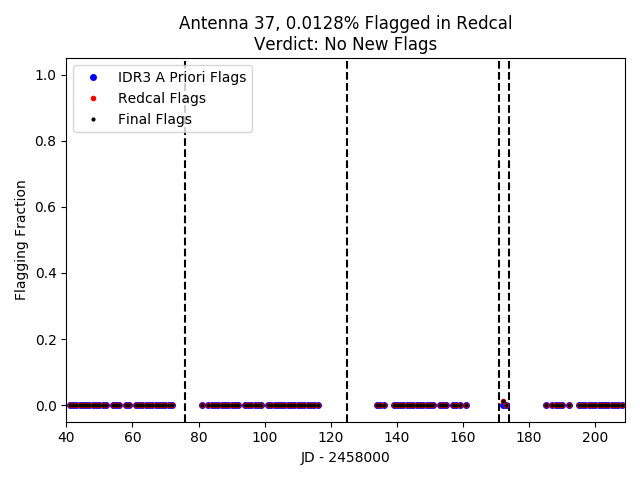

<IPython.core.display.Javascript object>


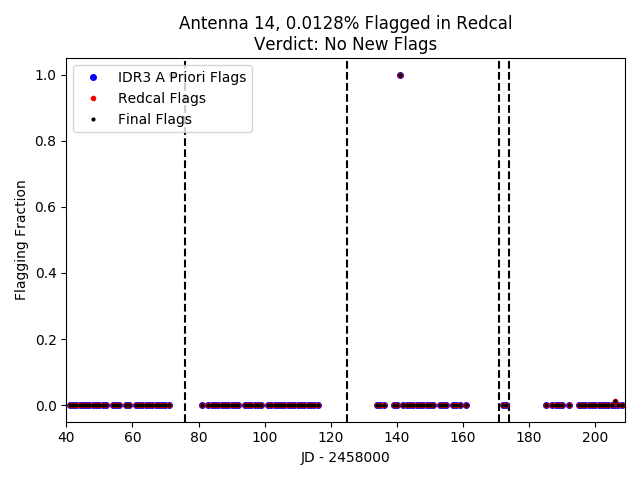

invalid value encountered in greater


<IPython.core.display.Javascript object>


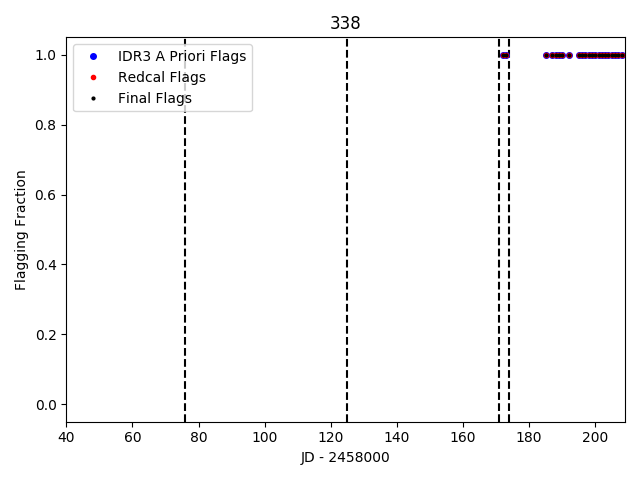

<IPython.core.display.Javascript object>


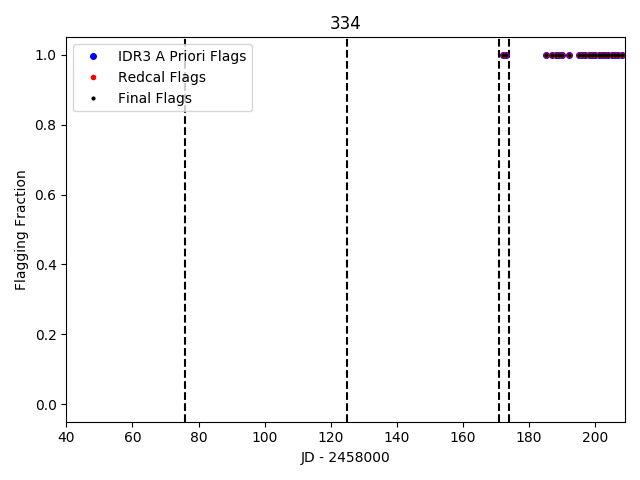

<IPython.core.display.Javascript object>


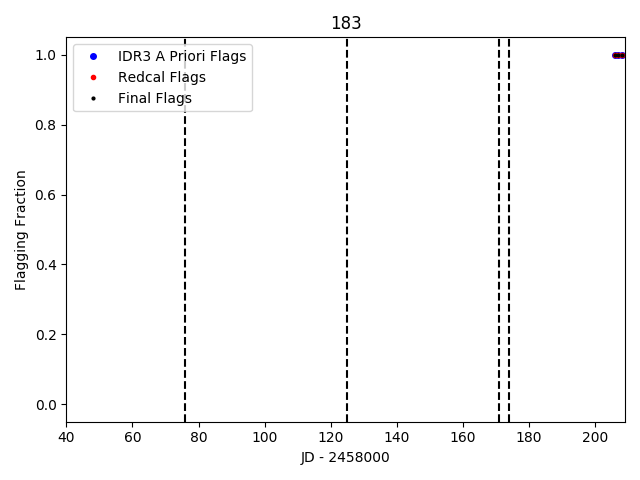

<IPython.core.display.Javascript object>


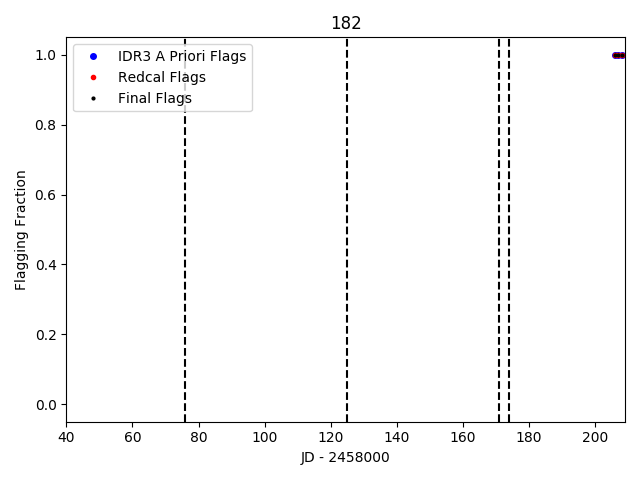

<IPython.core.display.Javascript object>


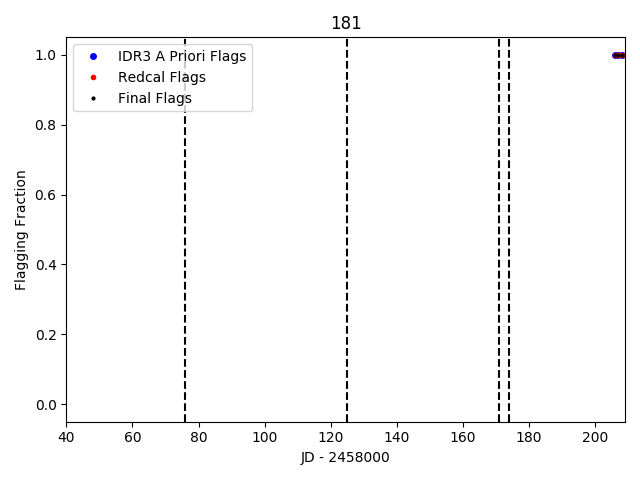

<IPython.core.display.Javascript object>


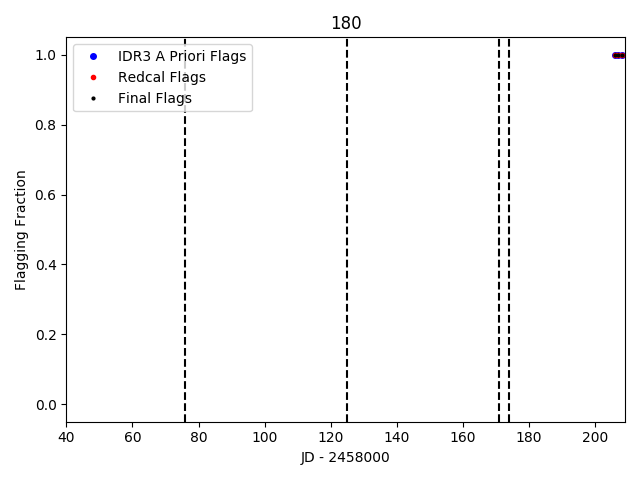

<IPython.core.display.Javascript object>


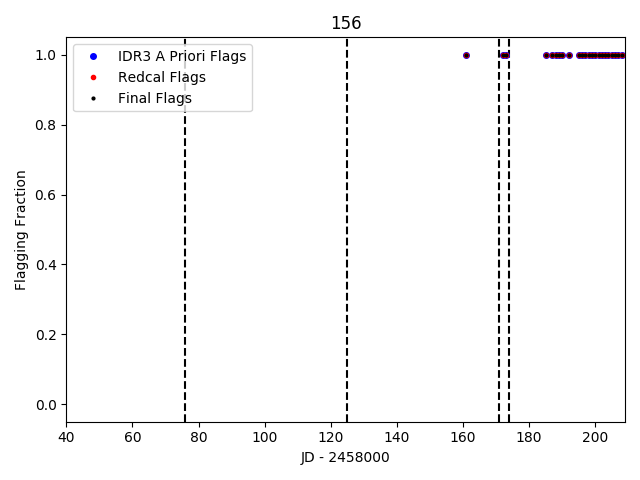

<IPython.core.display.Javascript object>


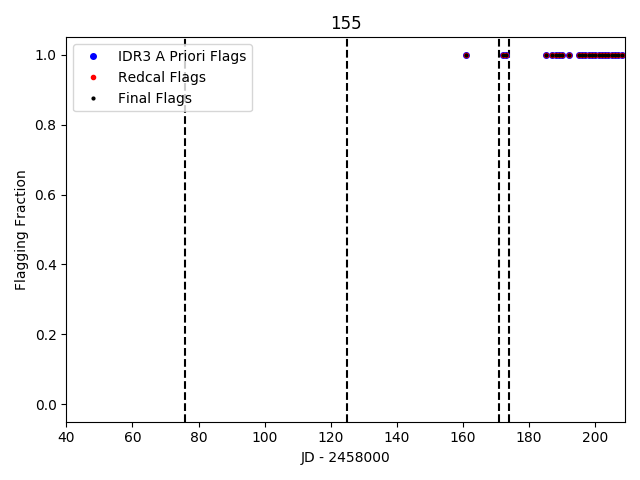

<IPython.core.display.Javascript object>


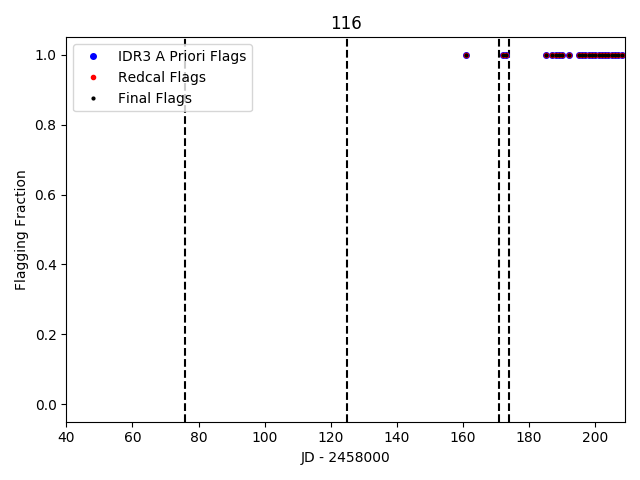

<IPython.core.display.Javascript object>


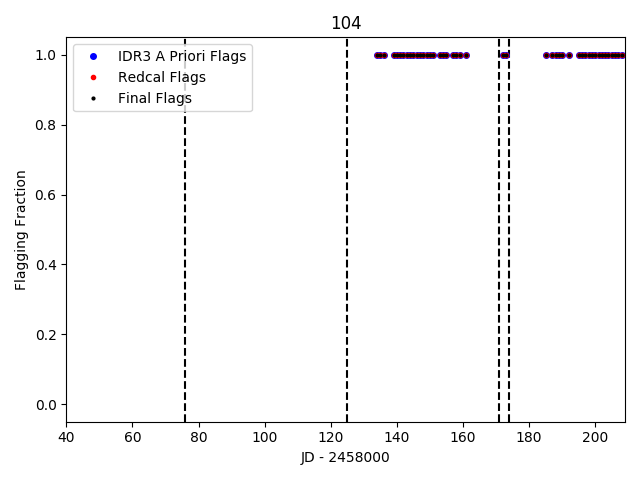

<IPython.core.display.Javascript object>


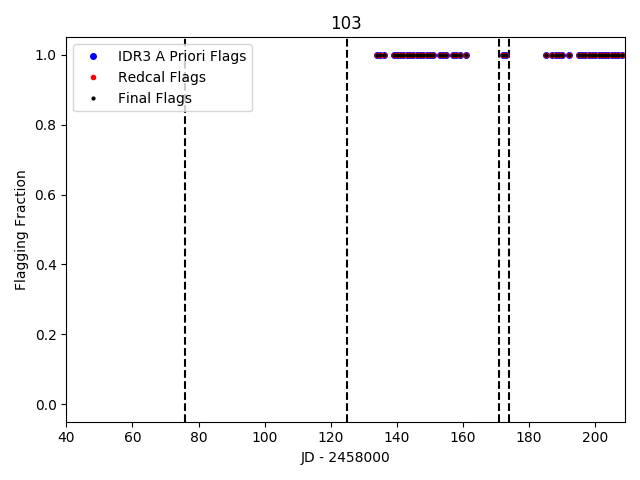

<IPython.core.display.Javascript object>


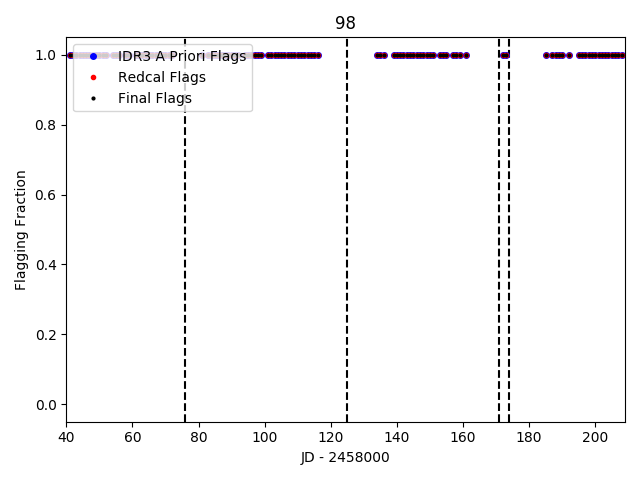

<IPython.core.display.Javascript object>


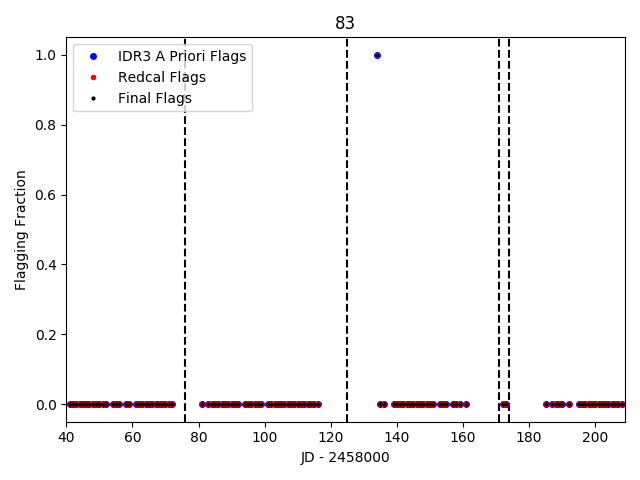

<IPython.core.display.Javascript object>


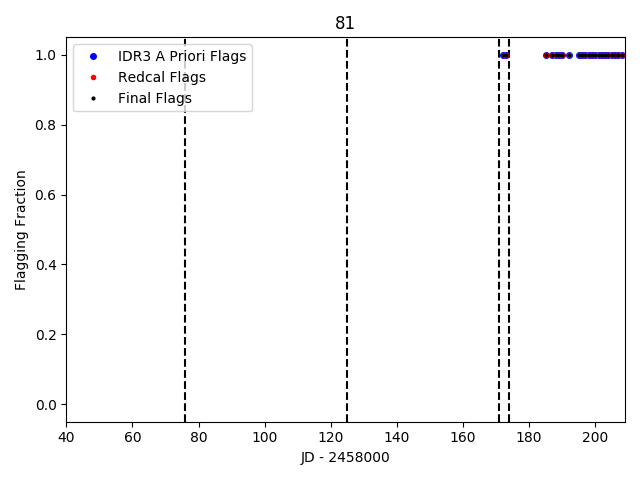

<IPython.core.display.Javascript object>


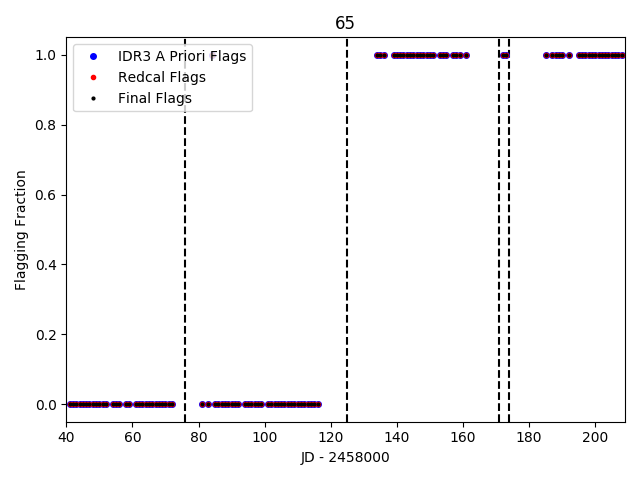

<IPython.core.display.Javascript object>


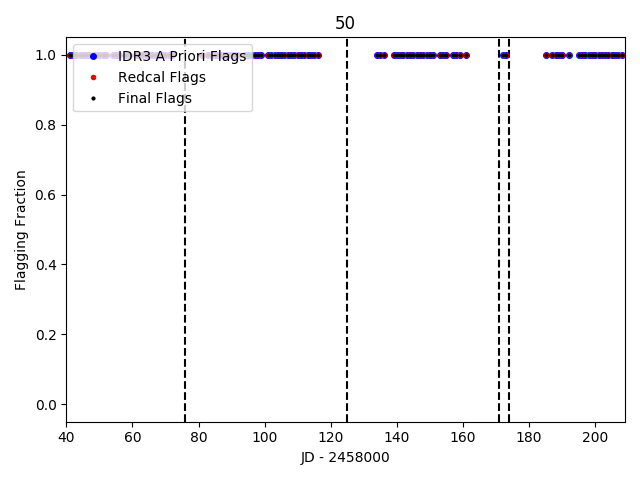

<IPython.core.display.Javascript object>


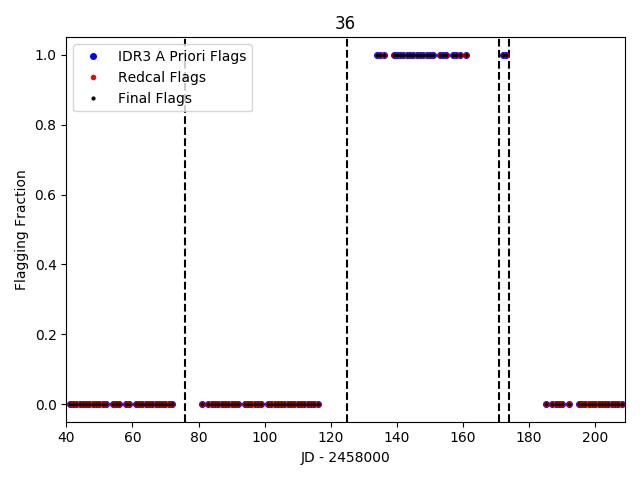

<IPython.core.display.Javascript object>


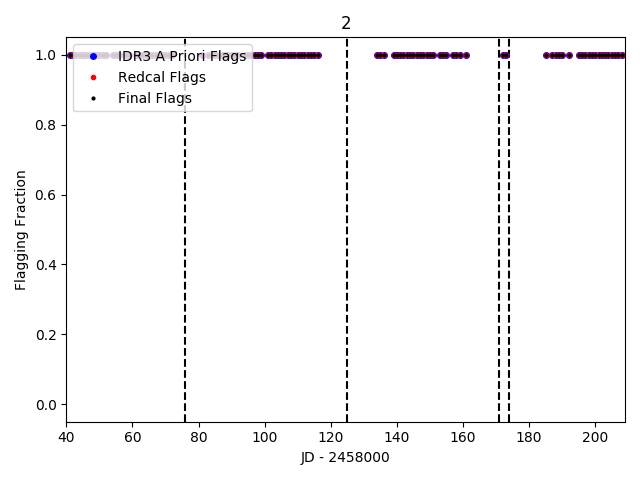

<IPython.core.display.Javascript object>


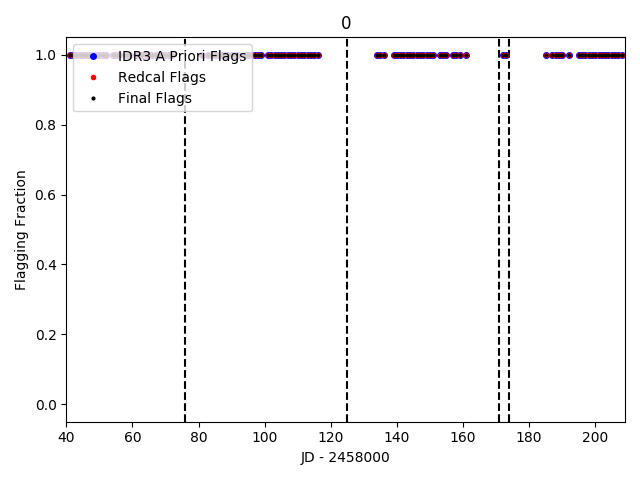

In [26]:
for redcal_flag_frac, ant in new_flag_levels:
    if redcal_flag_frac > 0 or np.any(np.array(ant_flag_fraction[ant]) > 0):
        plt.figure()
        plt.plot(jd_ints-2458000, ant_flag_apriori_fraction[ant],'bo', ms=4, label='IDR3 A Priori Flags')
        plt.plot(jd_ints-2458000, ant_flag_fraction[ant],'ro', ms=3, label='Redcal Flags') 
        plt.plot(jd_ints-2458000, ant_flag_fraction_final[ant],'ko', ms=2, label='Final Flags')
        plt.vlines([76, 125, 171, 174], -.05,1.05, ls='--')
        plt.ylim([-.05, 1.05])
        plt.xlim([np.min(jd_ints)-1-2458000, np.max(jd_ints)+1-2458000])    
        try:
            plt.title('Antenna {}, {}% Flagged in Redcal{}\nVerdict: {}'.format(ant, round(100*redcal_flag_frac,4), 
                                                                     ['', ', Flagged in IDR2.2'][ant in IDR22_excluded],
                                                                     verdicts[ant]))
        except:
            plt.title(ant)
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.xlabel('JD - 2458000')
        plt.ylabel('Flagging Fraction')
        plt.tight_layout()
